In [1]:
import cv2
import numpy as np
import os
import pytesseract as pt
import matplotlib.pyplot as plt

In [2]:
# settings 
INPUT_WIDTH = 640
INPUT_HEIGHT = 640

(-0.5, 4607.5, 2591.5, -0.5)

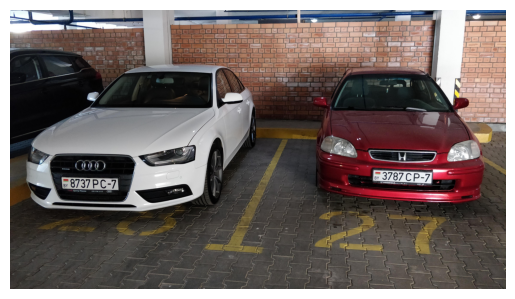

In [3]:
# LOAD the IMAGE
img = cv2.imread("dataset/yolo_testing/139.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

In [4]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX("./Model/weights/best.onnx")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

(-0.5, 4607.5, 4607.5, -0.5)

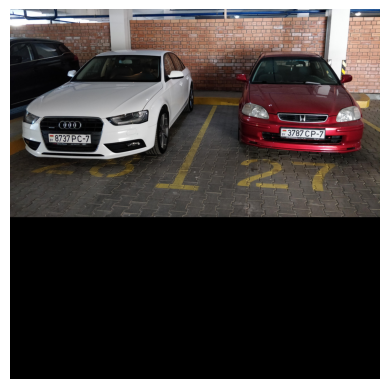

In [5]:
# CONVERT IMAGE TO YOLO FORMAT
image = img.copy()
row, col, d = image.shape

max_rc = max(row, col)
input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)
input_image[0:row, 0:col] = image
plt.imshow(input_image)
plt.axis("off")

In [6]:
# GET PREDICTIONS FROM YOLO MODEL

blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
net.setInput(blob)
preds = net.forward()
detections = preds[0]

In [7]:
detections.shape

(25200, 6)

In [8]:
# FILTER DETECTIONS BASED ON CONFIDENCE PROBABILITY SCORE
# center_x, center_y, w, h, conf, probab.

boxes = []
confidences = []

image_w, image_h = input_image.shape[:2]
x_factor = image_w / INPUT_WIDTH
y_factor = image_h / INPUT_HEIGHT

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4] # confidence of detecting license plate
    if confidence > 0.4:
        class_score = row[5] # probability score of license plate
        if class_score > 0.25:
            cx, cy, w, h = row[0:4]
            
            left = int((cx - 0.5 * w) * x_factor)
            top = int((cy - 0.5 * h) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)
            box = np.array([left,top,width,height])
            
            confidences.append(confidence)
            boxes.append(box)

In [9]:
boxes[:5]

[array([3358, 1477,  547,  132]),
 array([3350, 1480,  559,  129]),
 array([ 457, 1528,  573,  160]),
 array([ 460, 1530,  574,  159]),
 array([3353, 1477,  548,  135])]

In [10]:
# Clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

In [11]:
boxes_np[:5]

[[3358, 1477, 547, 132],
 [3350, 1480, 559, 129],
 [457, 1528, 573, 160],
 [460, 1530, 574, 159],
 [3353, 1477, 548, 135]]

In [12]:
confidences_np[:5]

[0.7752436399459839,
 0.7888811826705933,
 0.7853169441223145,
 0.7764796614646912,
 0.5652778744697571]

In [13]:
# NMS
index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45).flatten()

In [14]:
index

array([13,  1])

(-0.5, 4607.5, 2591.5, -0.5)

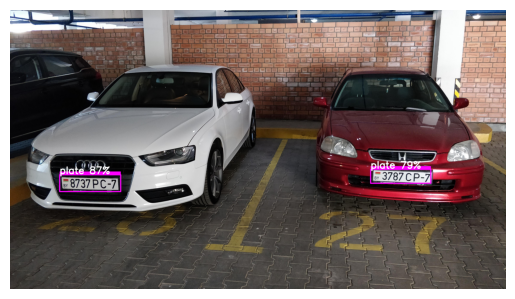

In [15]:
# Draw
for ind in index:
    x,y,w,h = boxes_np[ind]
    bb_conf = confidences_np[ind]
    conf_text = "plate {:.0f}%".format(bb_conf*100)

    
    cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,255), 10)
    cv2.rectangle(image, (x,y-30), (x+w, y), (255,0,255),-1)
    
    cv2.putText(image, conf_text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255),10)
    
plt.imshow(image)
plt.axis("off")